In [1]:
import thermalizer.models.misc as misc
import thermalizer.kolmogorov.simulate as simulate
import thermalizer.kolmogorov.performance as performance
import torch
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import kymatio
from kymatio.torch import Scattering2D

from torch import optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
sims_cut=-1
steps_cut=1
model_therm=misc.load_model("/scratch/cp3759/thermalizer_data/kolmogorov/model_weights.pt")
test_data=torch.load("/scratch/cp3759/thermalizer_data/kolmogorov/test_suite/all.pt")
print(test_data.shape)
test_data=test_data[:sims_cut,:steps_cut]/model_therm.config["field_std"]
print(test_data.shape)
test_data=test_data.to("cuda")

torch.Size([64, 10000, 64, 64])
torch.Size([63, 1, 64, 64])


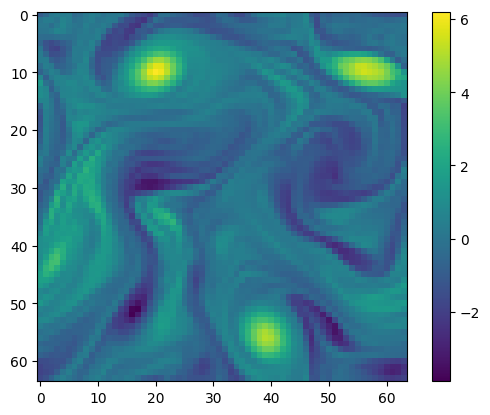

In [3]:
plt.imshow(test_data[0,0].cpu())
plt.colorbar()

In [4]:
scattering = Scattering2D(J=2, shape=(64,64), max_order=2)
scattering = scattering.cuda()

100%|██████████| 63/63 [00:02<00:00, 29.40it/s]


Text(0.5, 0, 'Scattering field number')

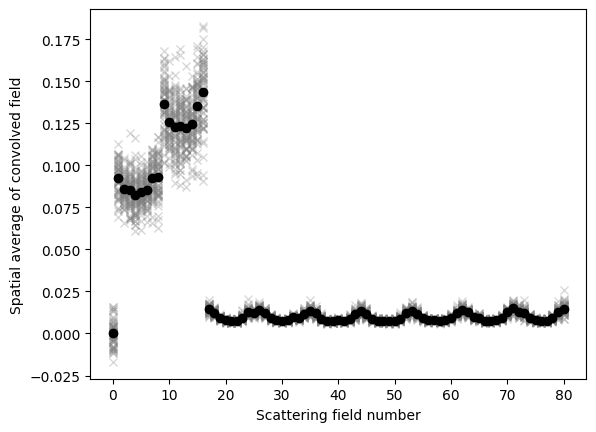

In [11]:
scatt_all=torch.zeros(len(test_data),64+16+1)
scatt_std=torch.zeros(len(test_data),64+16+1)
plt.figure("Scattering coefficients for randomly sampled true Kolmogorov fields")
losses=[]
## Plot scattering coeffs for each random flow sample
for aa in tqdm(range(len(test_data))):
    scattering_coefficients = scattering(test_data[aa,0])
    plt.plot(torch.mean(scattering_coefficients,dim=(1,2)).cpu(),"x",color="gray",alpha=0.3)
    scatt_all[aa]=torch.mean(scattering_coefficients,dim=(1,2))
    loss = F.mse_loss(input=torch.mean(scattering_coefficients,dim=(1,2)).cpu(), target=scatt_means)
    losses.append(loss)
plt.plot(torch.mean(scatt_all,axis=0),"o",color="black")
plt.ylabel("Spatial average of convolved field")
plt.xlabel("Scattering field number")
#plt.yscale("log")

In [8]:
from scipy.stats import multivariate_normal
multivariate_normal.logpdf(x=point, mean=mu, cov=sigma)

In [12]:
scatt_means=torch.mean(scatt_all,axis=0)
scatt_cov=torch.diag(torch.std(scatt_all,axis=0))

In [16]:
torch.mean(scattering_coefficients[1:],axis=(1,2))

tensor([0.1048, 0.0829, 0.0750, 0.0710, 0.0793, 0.0877, 0.1009, 0.1168, 0.1500,
        0.1178, 0.1082, 0.1105, 0.1162, 0.1213, 0.1405, 0.1665, 0.0200, 0.0157,
        0.0105, 0.0078, 0.0072, 0.0088, 0.0137, 0.0203, 0.0136, 0.0140, 0.0117,
        0.0093, 0.0077, 0.0073, 0.0089, 0.0120, 0.0088, 0.0103, 0.0115, 0.0104,
        0.0077, 0.0062, 0.0063, 0.0076, 0.0061, 0.0069, 0.0092, 0.0110, 0.0092,
        0.0067, 0.0061, 0.0063, 0.0059, 0.0058, 0.0076, 0.0110, 0.0118, 0.0099,
        0.0080, 0.0070, 0.0078, 0.0067, 0.0068, 0.0086, 0.0111, 0.0130, 0.0125,
        0.0106, 0.0120, 0.0080, 0.0069, 0.0073, 0.0091, 0.0128, 0.0177, 0.0176,
        0.0197, 0.0117, 0.0081, 0.0075, 0.0077, 0.0108, 0.0191, 0.0260],
       device='cuda:0')

In [64]:
cmap = matplotlib.cm.get_cmap('cool') 

In [79]:
scatt_std.cpu()

tensor([0.0095, 0.0075, 0.0099, 0.0106, 0.0086, 0.0075, 0.0100, 0.0117, 0.0156,
        0.0127, 0.0157, 0.0159, 0.0138, 0.0127, 0.0167, 0.0198, 0.0020, 0.0016,
        0.0008, 0.0007, 0.0007, 0.0007, 0.0012, 0.0019, 0.0013, 0.0016, 0.0014,
        0.0010, 0.0007, 0.0006, 0.0007, 0.0009, 0.0008, 0.0013, 0.0020, 0.0017,
        0.0011, 0.0007, 0.0007, 0.0006, 0.0007, 0.0010, 0.0018, 0.0022, 0.0017,
        0.0010, 0.0007, 0.0007, 0.0007, 0.0008, 0.0011, 0.0016, 0.0019, 0.0014,
        0.0009, 0.0007, 0.0007, 0.0007, 0.0008, 0.0010, 0.0015, 0.0019, 0.0015,
        0.0009, 0.0011, 0.0007, 0.0006, 0.0007, 0.0009, 0.0016, 0.0021, 0.0018,
        0.0020, 0.0011, 0.0007, 0.0007, 0.0007, 0.0012, 0.0021, 0.0028])

In [55]:
min=torch.min(logprobs)
max=torch.max(logprobs)

In [82]:
m = torch.distributions.MultivariateNormal(scatt_means, scatt_cov)

In [95]:
scatt_means.repeat(10,1).shape

torch.Size([10, 80])

In [96]:
m.log_prob(scatt_means.repeat(10,1))

tensor([180.7053, 180.7053, 180.7053, 180.7053, 180.7053, 180.7053, 180.7053,
        180.7053, 180.7053, 180.7053])

In [10]:
scatt_means=torch.tensor([0.0, 0.0923, 0.0862, 0.0851, 0.0824, 0.0841, 0.0855, 0.0925, 0.0932, 0.1364,
        0.1256, 0.1228, 0.1233, 0.1220, 0.1248, 0.1355, 0.1439, 0.0145, 0.0124,
        0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125, 0.0142, 0.0121,
        0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119, 0.0135, 0.0120,
        0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113, 0.0133, 0.0113,
        0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119, 0.0135, 0.0118,
        0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121, 0.0142, 0.0126,
        0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126, 0.0149, 0.0130,
        0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126, 0.0149])

#scatt_cov=torch.diag(scatt_std)
    
    

In [59]:
def rescale(val):
    return (val-min)/(max-min)

In [77]:
multivariate_normal.logpdf(x=scatt_means.cpu(), mean=scatt_means.cpu(), cov=scatt_cov.cpu())

180.47265549677905

In [76]:
torch.max(logprobs)

tensor(180.4592)

In [54]:
logprobs=torch.zeros(len(test_data))
for aa in tqdm(range(len(test_data))):
    #scattering_coefficients = scattering(test_data[aa,0])
    logprobs[aa]=multivariate_normal.logpdf(x=scatt_all[aa].cpu(), mean=scatt_means.cpu(), cov=scatt_cov.cpu())

100%|██████████| 63/63 [00:00<00:00, 742.75it/s]


100%|██████████| 63/63 [00:00<00:00, 583.51it/s]


Text(0.5, 1.0, 'Points coloured by logprob wrt gaussian model - diagonal cov')

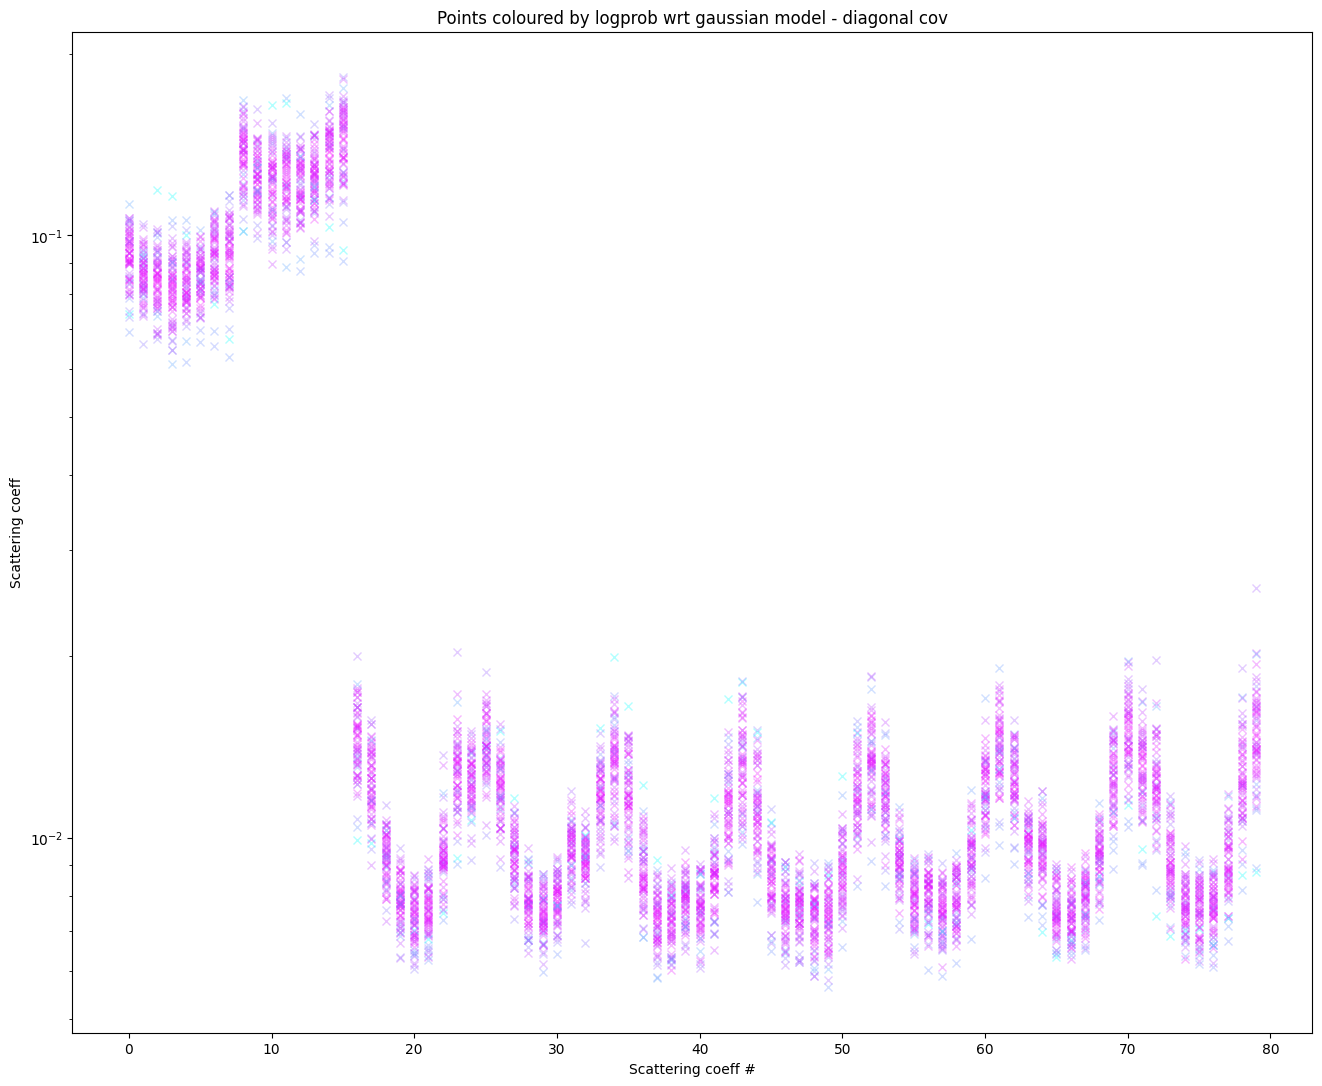

In [73]:

plt.figure(figsize=(16,13))
for aa in tqdm(range(len(test_data))):
    plt.plot(scatt_all[aa].cpu(),"x",color=cmap(rescale(logprobs[aa]).numpy()),alpha=0.3)
plt.yscale("log")
plt.xlabel("Scattering coeff #")
plt.ylabel("Scattering coeff")
plt.title("Points coloured by logprob wrt gaussian model - diagonal cov")

In [7]:
## Pre-calculated 2nd order scattering coefficients
scattering_objective=torch.tensor([0.0145, 0.0124, 0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125,
        0.0142, 0.0121, 0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119,
        0.0135, 0.0120, 0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113,
        0.0133, 0.0113, 0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119,
        0.0135, 0.0118, 0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121,
        0.0142, 0.0126, 0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126,
        0.0149, 0.0130, 0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126,
        0.0149],device=device)
## Expand along batch dim
#scattering_objective=scattering_objective.repeat(len(test_data),1)

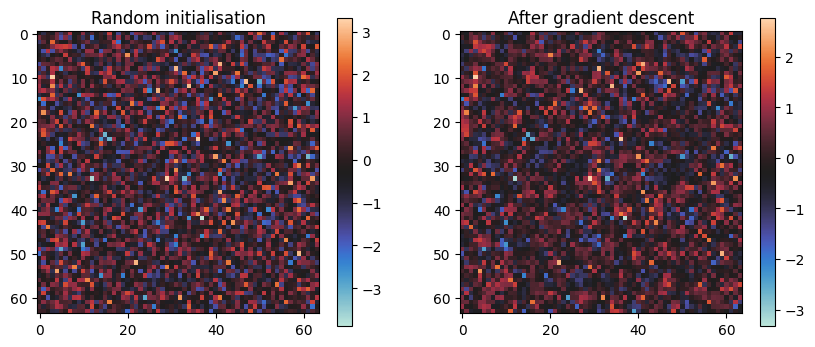

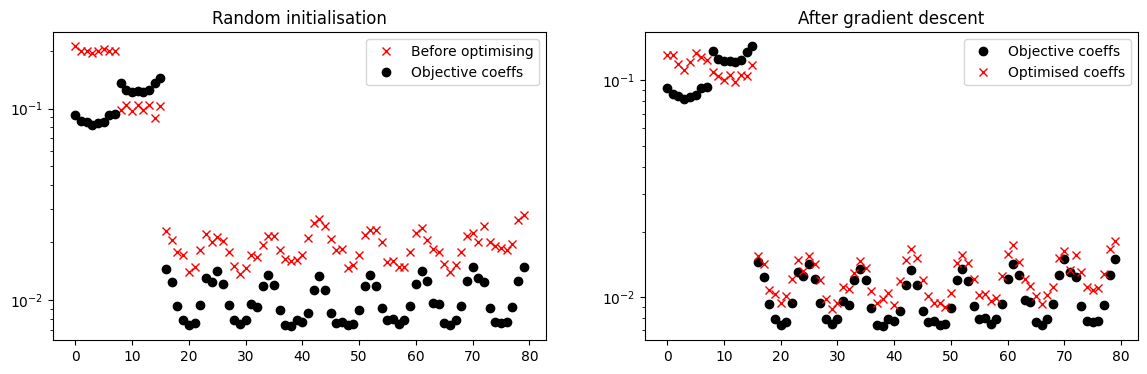

In [47]:
## Create batch of randomly drawn fields
input_tensor = torch.randn((64,64), requires_grad=True, device=device)
init_field=input_tensor.detach().cpu()
new_coefficients = scattering(input_tensor)
init_scats=torch.mean(new_coefficients[1:],axis=(-2,-1)).detach().cpu()

scatt_means=scatt_means.to("cuda")

optimizer = optim.Adam([input_tensor], lr=0.05)

loss=100
aa=0
losses=[]
while loss>0.00025:
    optimizer.zero_grad()
    new_coefficients = scattering(input_tensor)
    loss = F.mse_loss(input=torch.mean(new_coefficients[1:],axis=(-2,-1)).squeeze(), target=scatt_means)
    print("Epoch {}, loss: {}".format(aa, loss.item()), end="\r")
    loss.backward()
    optimizer.step()
    aa+=1
    losses.append(loss.detach().cpu())



### Plot output for a randomly chosen batch element
#dex=np.random.randint(len(test_data))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Random initialisation")
plt.imshow(init_field.squeeze(),cmap=sns.cm.icefire)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("After gradient descent")
plt.imshow(input_tensor.squeeze().detach().cpu(),cmap=sns.cm.icefire)
plt.colorbar()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title("Random initialisation")
plt.plot(init_scats.squeeze(),"x",color="red",label="Before optimising")
plt.plot(scatt_means.detach().cpu(),"o",color="black",label="Objective coeffs")
plt.legend()
plt.yscale("log")
#plt.ylim(0.005,0.027)
plt.subplot(1,2,2)
plt.title("After gradient descent")
new_coefficients = scattering(input_tensor)
plt.plot(scatt_means.detach().cpu(),"o",color="black",label="Objective coeffs")
plt.plot(torch.mean(new_coefficients[1:],axis=(-2,-1)).squeeze().detach().cpu(),"x",color="red",label="Optimised coeffs")
plt.legend()
plt.yscale("log")
#plt.ylim(0.005,0.027)